## Libraries

In [1]:
import networkx as nx
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allowing the plot in line for seaborn
%matplotlib inline
plt.style.use('seaborn')

# enabling outlines line in histogram 
plt.rcParams["patch.force_edgecolor"] = True

## Function

In [3]:
def save_img(title):    
    plt.savefig('/Users/villons/Desktop/echo-chamers/src/analysis_images/'+title+'.png', 
                dpi = 300, quality = 95, format = 'png', pad_inches = 1000)
    
def community_pie_chart(graph, comm_type, name):
    
    communities = dict()
    for node in graph.nodes(data=True):
        if not(f'Comunità: {node[1][comm_type]}' in communities):
            communities[f'Comunità: {node[1][comm_type]}'] = 1
        else:
            communities[f'Comunità: {node[1][comm_type]}'] += 1
            
            
    com = list(communities.keys())
    com_comp = list(communities.values())
    colors = ['#0045b5', '#b50000']
    if com[0] != 'Comunità: 1':
        com[0], com[1] = com[1], com[0]
        com_comp[0], com_comp[1] = com_comp[1], com_comp[0]

    print(communities)
    
    fig, ax = plt.subplots()
    ax.pie(com_comp, labels = com, explode = [0, 0.1], shadow=True,
        startangle = 90, colors = colors, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f'Suddivisione community per {name}')
    save_img(f'Suddivisione community per {name}')
    plt.show() 

## Garimella


In [ ]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/garimella_data')

In [ ]:
beefban = nx.read_gml('./Graph/beefban.gml')
ukraine = nx.read_gml('./Graph/ukraine.gml')
kissing_day = nx.read_gml('./Graph/nationalkissingday.gml')

In [ ]:
community_pie_chart(beefban, 'weightComm', 'BeefBan con approccio strutturale')
community_pie_chart(ukraine, 'weightComm', 'Ukraine con approccio strutturale')
community_pie_chart(kissing_day, 'weightComm', 'Kissingday con approccio strutturale')

## Covid-19

In [4]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/corona_virus')

In [5]:
covid_compact = nx.read_gml('./Graph/Final_Graph_Covid.gml')
covid_complete = nx.read_gml('./Graph/Final_DiGraph_Covid.gml')
covid_metadata = nx.read_gml('./Graph/Final_DiGraph_Covid_data.gml')

{'Comunità: 0': 12251, 'Comunità: 1': 11556}


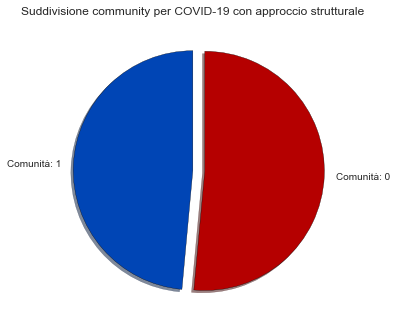

{'Comunità: 0': 12250, 'Comunità: 1': 11557}


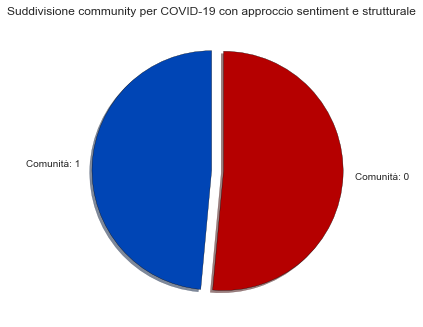

{'Comunità: 0': 12246, 'Comunità: 1': 11561}


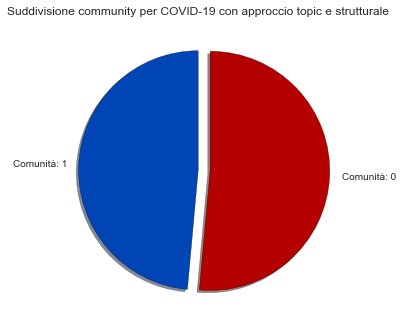

{'Comunità: 0': 11557, 'Comunità: 1': 12250}


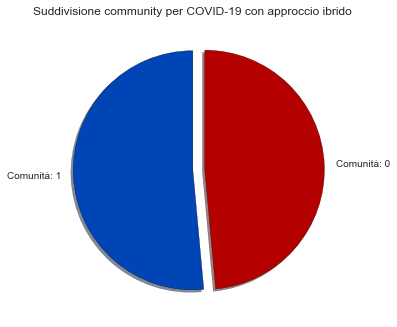

In [6]:
community_pie_chart(covid_compact, 'weightComm', 'COVID-19 con approccio strutturale')
community_pie_chart(covid_compact, 'sentimentComm', 'COVID-19 con approccio sentiment e strutturale')
community_pie_chart(covid_compact, 'topicComm', 'COVID-19 con approccio topic e strutturale')
community_pie_chart(covid_compact, 'hybridComm', 'COVID-19 con approccio ibrido')

## Vax

In [7]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/vax_no_vax')

In [8]:
vax_compact = nx.read_gml('Graph/Final_Graph_vax.gml')
vax_complete = nx.read_gml('Graph/Final_DiGraph_Vax.gml')

{'Comunità: 1': 19796, 'Comunità: 0': 19808}


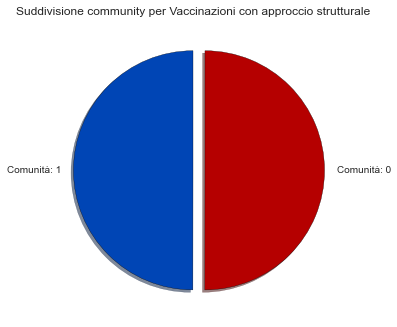

{'Comunità: 0': 19525, 'Comunità: 1': 20079}


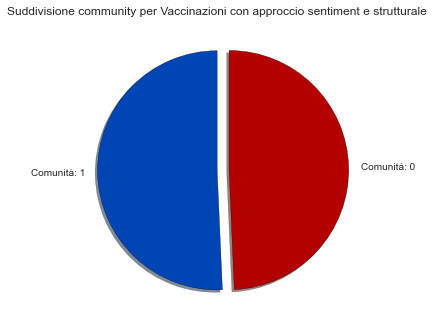

{'Comunità: 1': 19543, 'Comunità: 0': 20061}


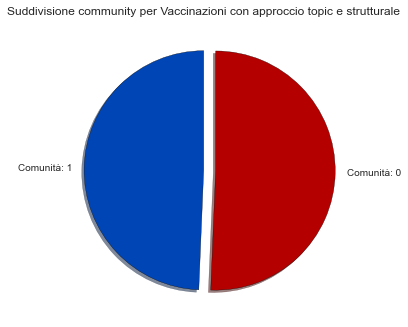

{'Comunità: 1': 19634, 'Comunità: 0': 19970}


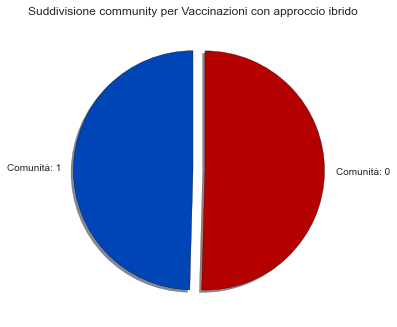

In [10]:
community_pie_chart(vax_compact, 'weightComm', 'Vaccinazioni con approccio strutturale')
community_pie_chart(vax_compact, 'sentimentComm', 'Vaccinazioni con approccio sentiment e strutturale')
community_pie_chart(vax_compact, 'topicComm', 'Vaccinazioni con approccio topic e strutturale')
community_pie_chart(vax_compact, 'hybridComm', 'Vaccinazioni con approccio ibrido')